In [827]:
import warnings
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,coint
from scipy.stats import pearsonr
warnings.filterwarnings("ignore")
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'



2.8.0


In [828]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [829]:
% cd "/content/drive/MyDrive/DataAnalytics"

/content/drive/MyDrive/DataAnalytics


In [830]:
df_covid = pd.read_csv('covid.csv')
df_vaccination = pd.read_csv('us_state_vaccinations.csv')

In [831]:
vaccine2 = df_vaccination.copy()

us_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Washington DC', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
vaccine2 = vaccine2.loc[vaccine2['location'].isin(us_states)]
states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}
inv_map = {v: k for k, v in states.items()}
vaccine2['state_abbrev'] = vaccine2['location'].map(inv_map)
vaccine2.head()

vaccine3 = df_vaccination.copy()
inv_map = {v: k for k, v in states.items()}
vaccine3['state_abbrev'] = vaccine3['location'].map(inv_map)
df_vaccination = vaccine3

In [832]:
def fetch_state_with_date(df_covid, df_vaccination,state ):

  df_covid['submission_date'] = pd.to_datetime(df_covid['submission_date'])
  df_covid = df_covid[(df_covid['state'] == state) & (df_covid['submission_date'] >= '2021-01-12')]
  df_covid = df_covid[['submission_date','new_case','new_death']]
  df_covid = df_covid.rename(columns={'submission_date' : 'date'})

  df_vaccination['date'] = pd.to_datetime(df_vaccination['date'])
  df_vaccination = df_vaccination[df_vaccination['state_abbrev']==state]

  df_vaccination = df_vaccination[['date','daily_vaccinations']]

  covid_vaccination_merged_df = df_covid.merge(df_vaccination, on='date')
  covid_vaccination_merged_df = covid_vaccination_merged_df.sort_values(by='date', ascending=True)
  covid_vaccination_merged_df = covid_vaccination_merged_df.dropna()
  return covid_vaccination_merged_df


In [833]:
df_covid = fetch_state_with_date(df_covid, df_vaccination, 'CA')

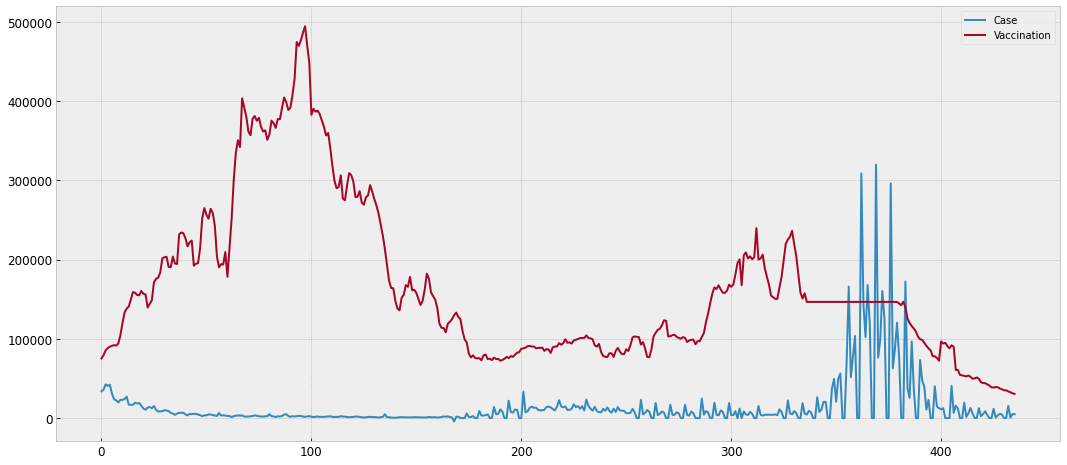

In [834]:
plt.plot(range(len(df_covid['new_case'].to_list())), df_covid['new_case'].to_list(), label='Case')
plt.plot(range(len(df_covid['daily_vaccinations'].to_list())), df_covid['daily_vaccinations'].to_list(), label='Vaccination')
plt.legend()
plt.show()

In [835]:
def remove_zero(x):
  if x ==0:
    return 1
  else :
    return x

In [836]:
#df_covid['new_case'] = df_covid['new_case'].apply(lambda x: remove_zero(x))

In [837]:
#df_covid

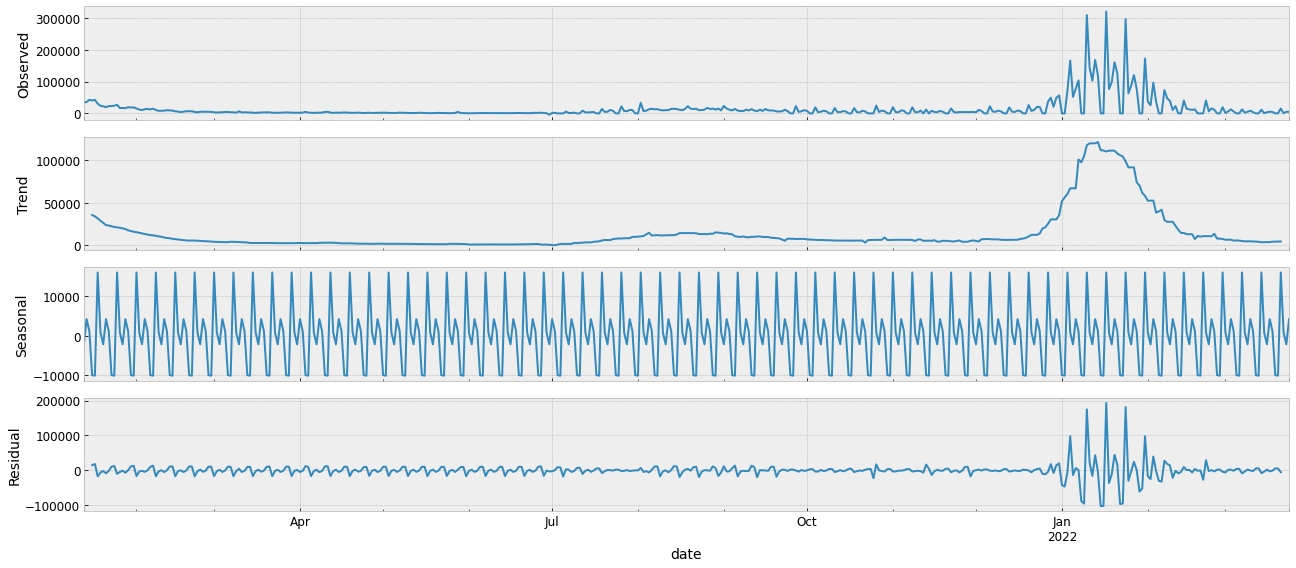

<Figure size 4000x1600 with 0 Axes>

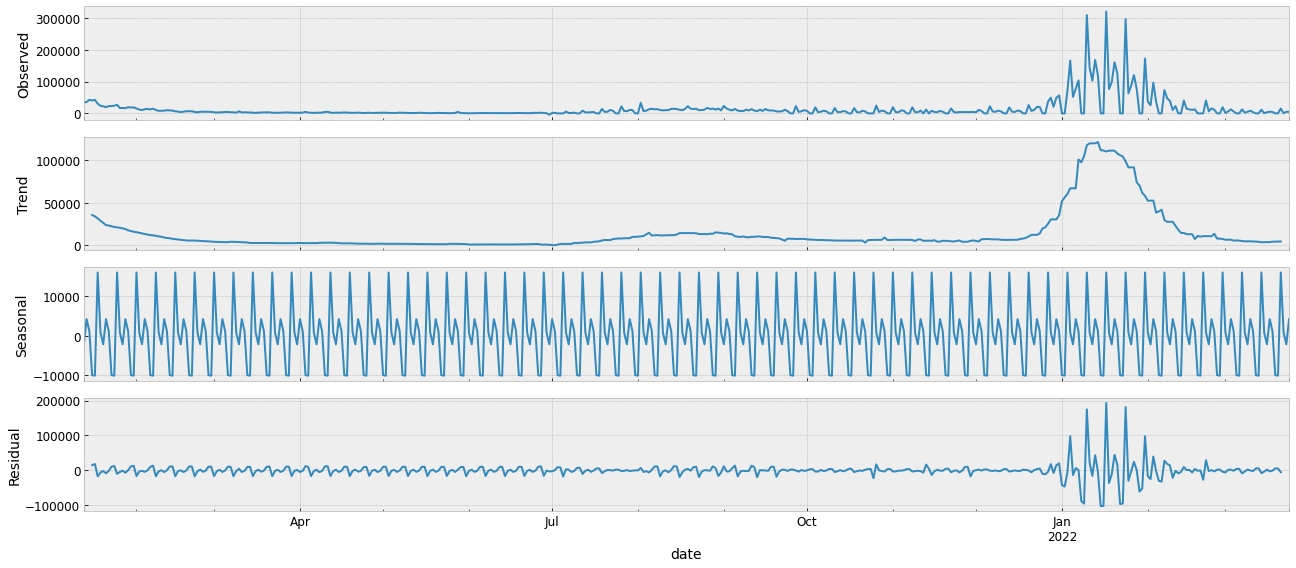

In [838]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')

series = df_covid.new_case
series.index = df_covid.date

result = seasonal_decompose(series, model='additive')
result.plot()


In [839]:
df_covid.new_case

date
2021-01-13    33751
2021-01-14    35930
2021-01-15    42655
2021-01-16    40622
2021-01-17    42229
              ...  
2022-03-20        0
2022-03-21    15349
2022-03-22      662
2022-03-23     5100
2022-03-24     4891
Name: new_case, Length: 436, dtype: int64

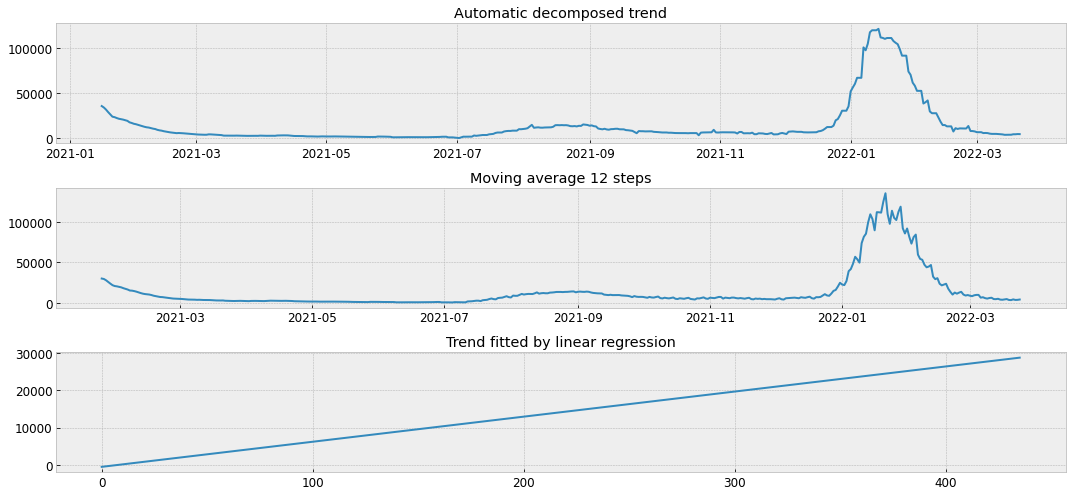

In [840]:


fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = series.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()



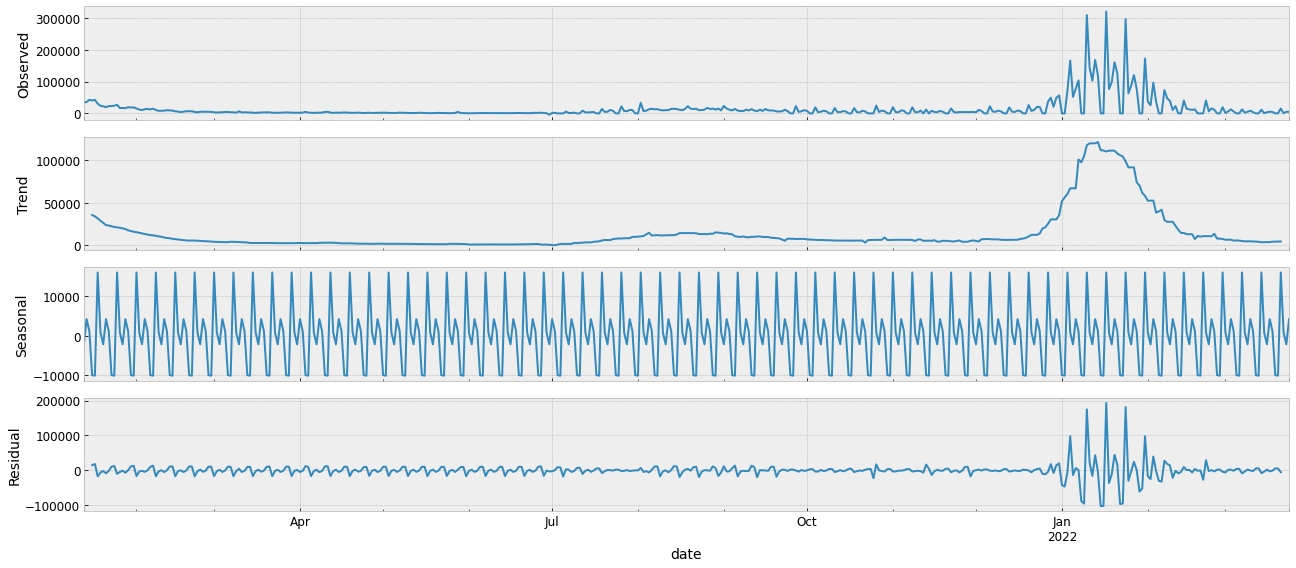

<Figure size 4000x1600 with 0 Axes>

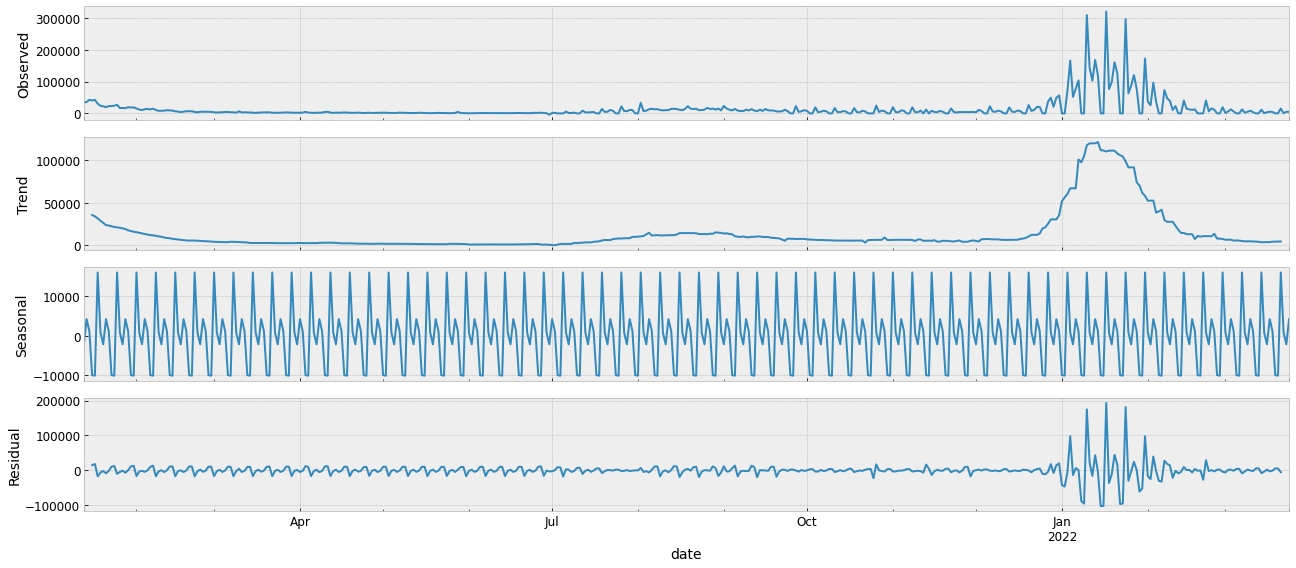

In [841]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
result = seasonal_decompose(series, model='additive')
result.plot()



date
2021-01-17    39037.400000
2021-01-24    23810.857143
2021-01-31    19171.000000
2021-02-07    13225.428571
2021-02-14     9136.000000
                  ...     
2022-02-27    10639.857143
2022-03-06     6503.714286
2022-03-13     4625.857143
2022-03-20     3674.285714
2022-03-27     6500.500000
Freq: W-SUN, Name: new_case, Length: 63, dtype: float64


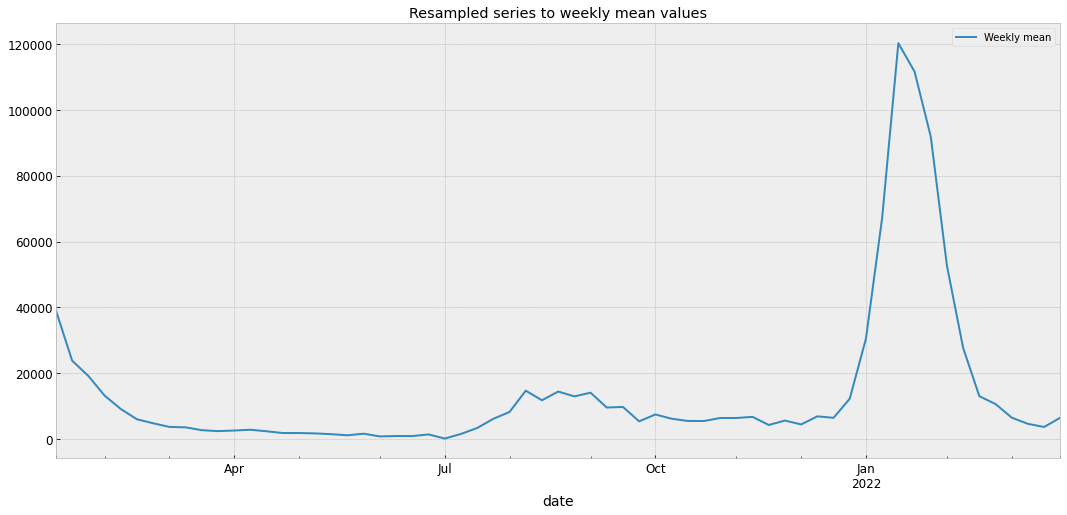

In [842]:


# Looking for weekly seasonality
resample = series.resample('W')
weekly_mean = resample.mean()
print(weekly_mean)
weekly_mean.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()



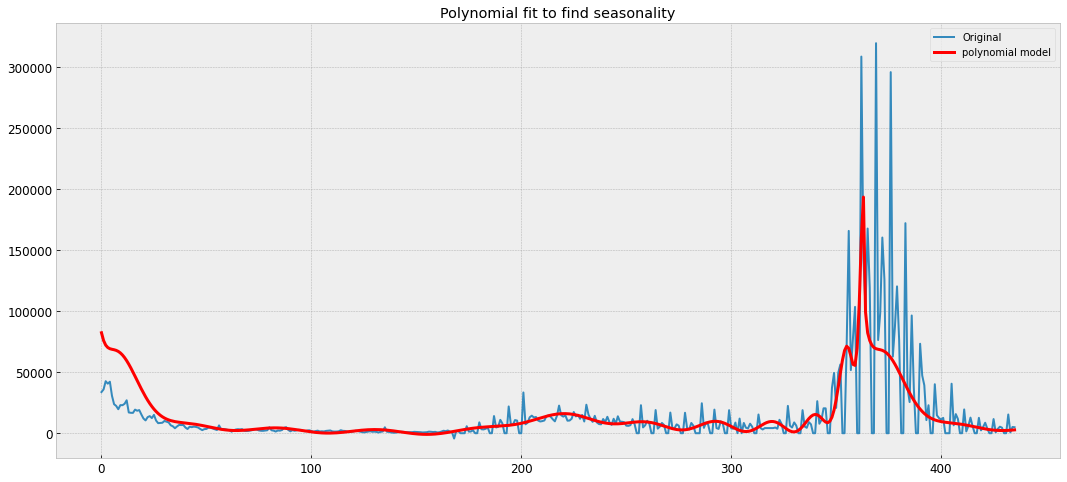

In [843]:
# Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series1 = series.values
X = [i % 365 for i in range(0, len(series1))]
y = series1
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series1, label='Original')
plt.plot(curve, color='red', linewidth=3, label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()



Text(0.5, 1.0, 'Mean over time')

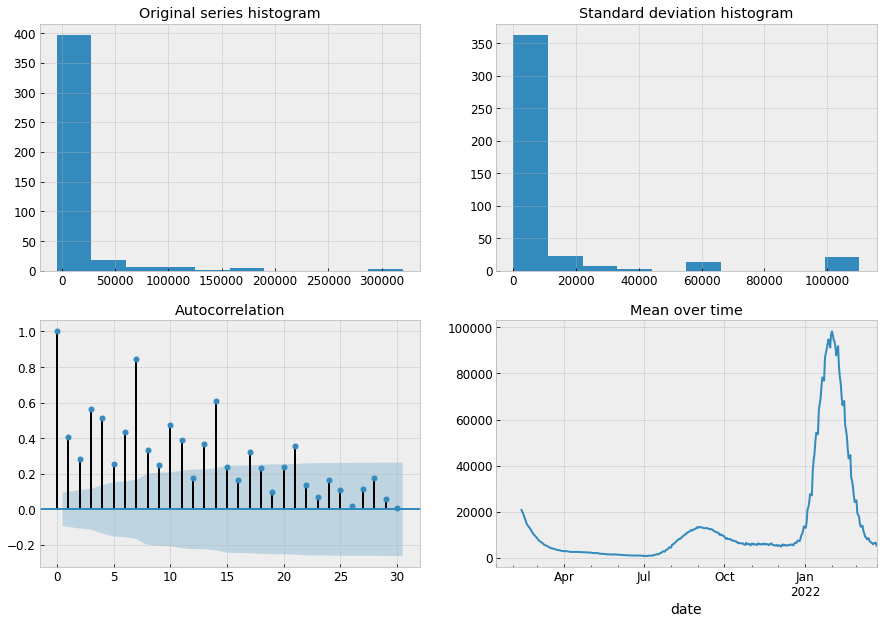

In [844]:
fig = plt.figure(figsize=(15, 10))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

series.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = series.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = series.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

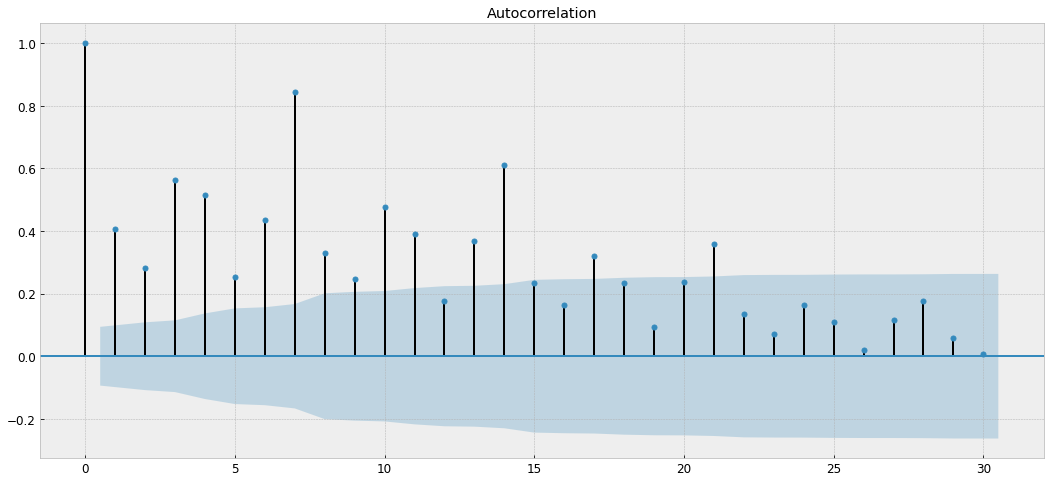

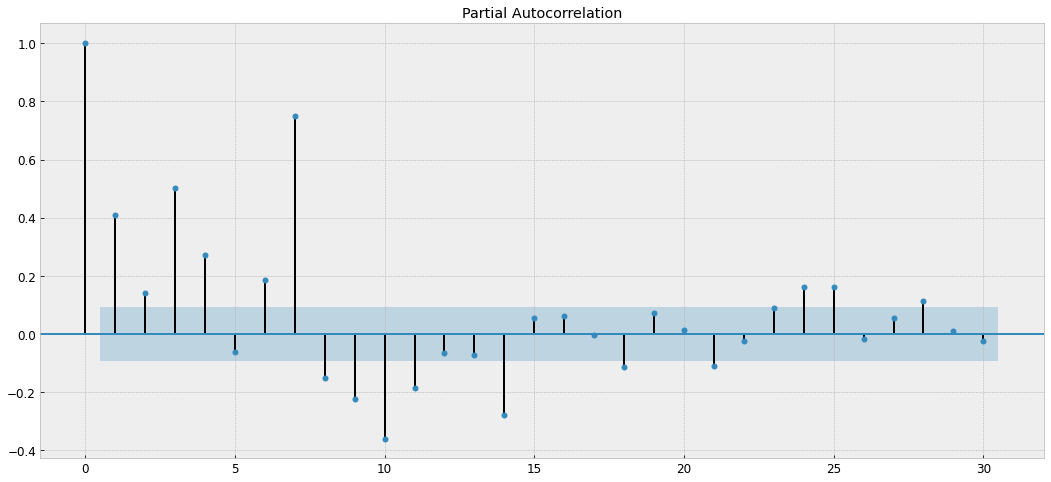

In [845]:


plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()



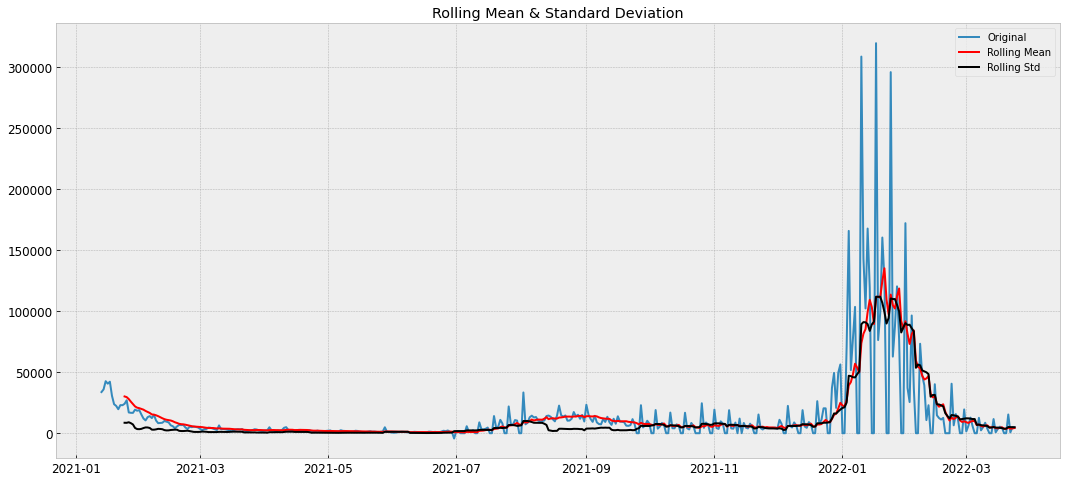

In [846]:


# Determing rolling statistics
rolmean = series.rolling(window=12).mean()
rolstd = series.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(series, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)



In [847]:
X = series1
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.198314
p-value: 0.000663
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570


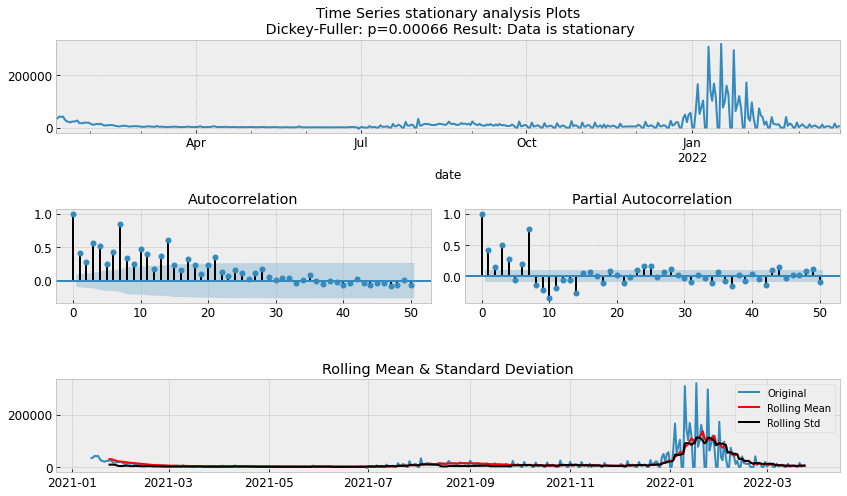

In [848]:


def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "Data is stationary" if p_value <= 0.05 else "Data is Non-stationary"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = y.rolling(window=12).mean()
        rolstd = y.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(y, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(series, lags=50)



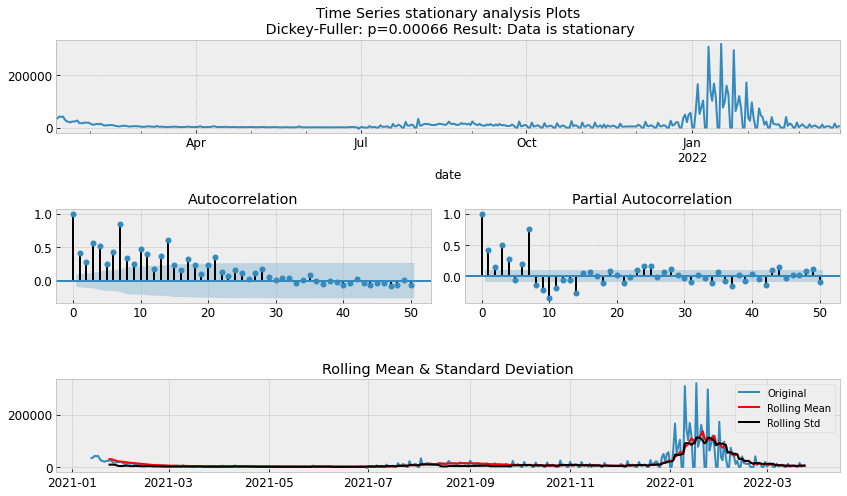

In [849]:
diff = series.shift(1).dropna()
tsplot(series, lags=50)

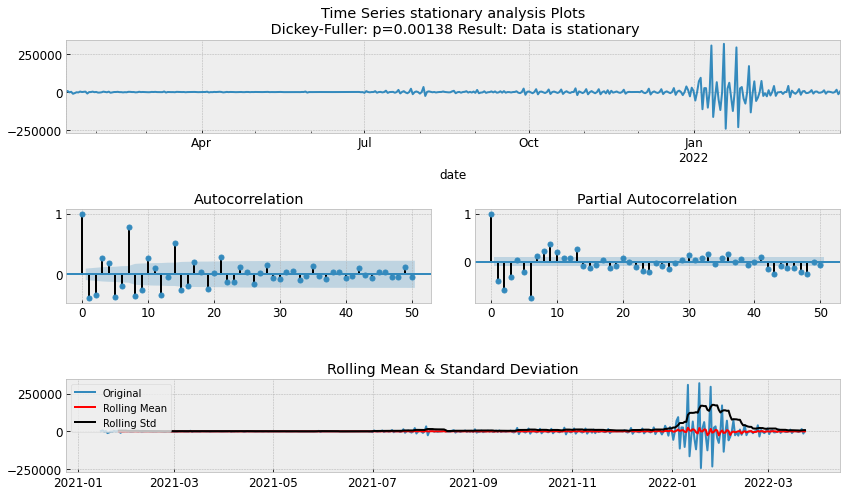

In [850]:
diff = diff.diff().dropna()
tsplot(diff, lags=50)

In [851]:
vaccination_series = df_covid.daily_vaccinations
vaccination_series.index = df_covid.date


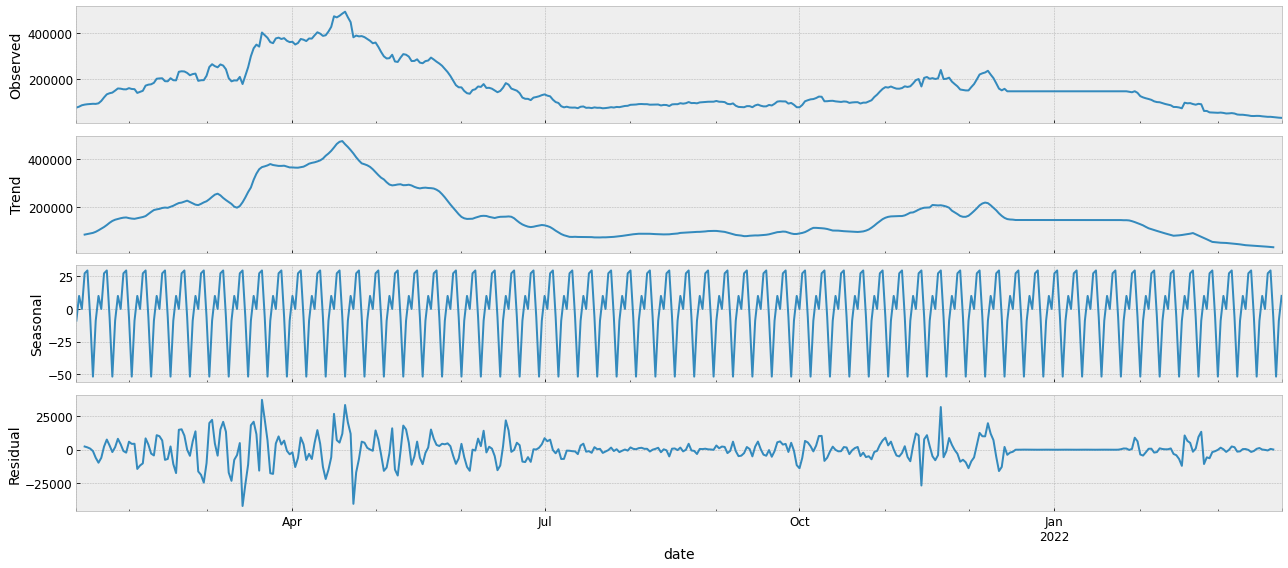

<Figure size 4000x1600 with 0 Axes>

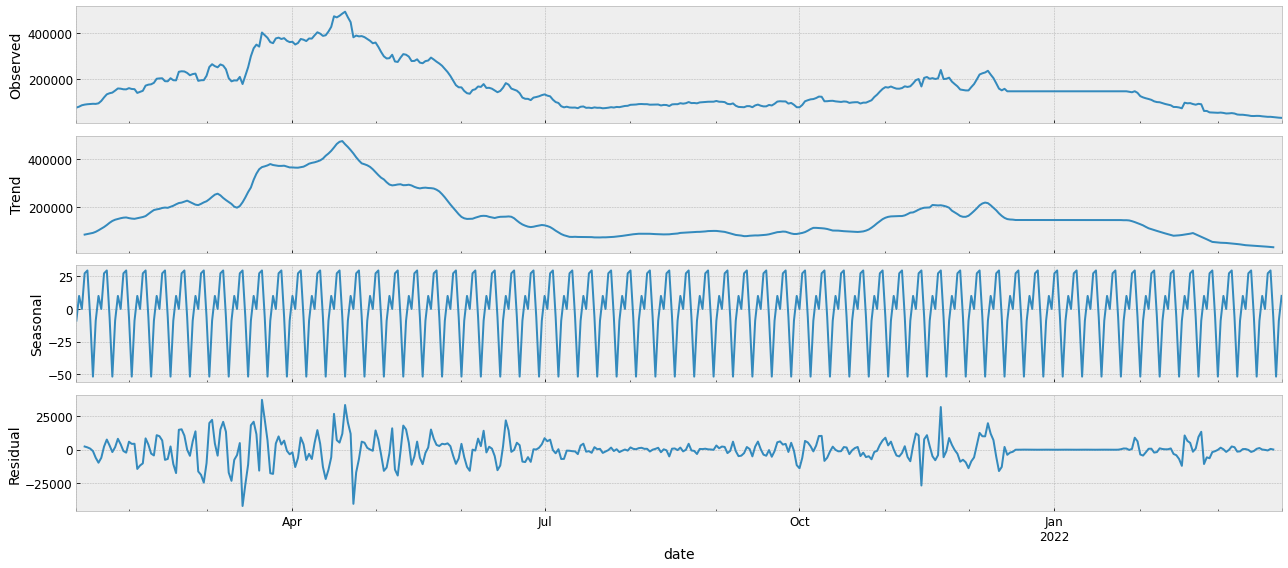

In [852]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
result = seasonal_decompose(vaccination_series, model='additive')
result.plot()

In [853]:
coint(vaccination_series[1:], series.shift(1).dropna())

(-1.3463299783713016,
 0.8153173463386398,
 array([-3.92185279, -3.3502448 , -3.05423679]))

In [854]:
pearsonr(series, vaccination_series)

(-0.1149706420374027, 0.016317533482643712)

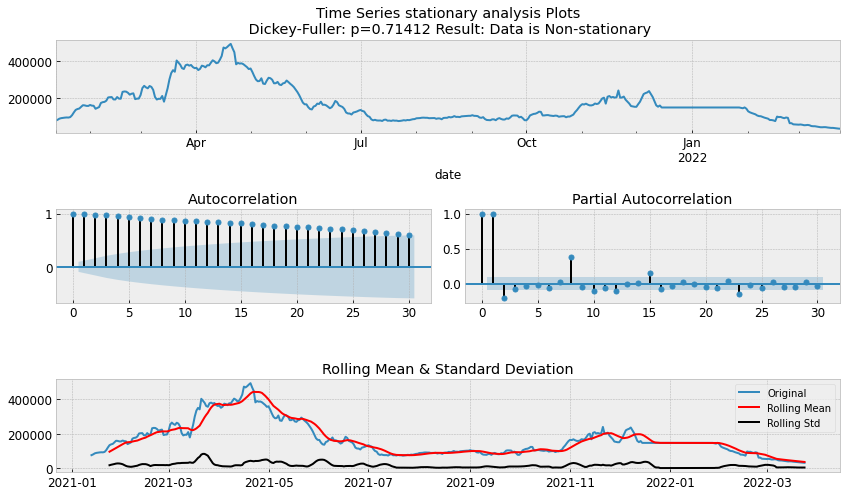

In [855]:
tsplot(vaccination_series, lags=30)

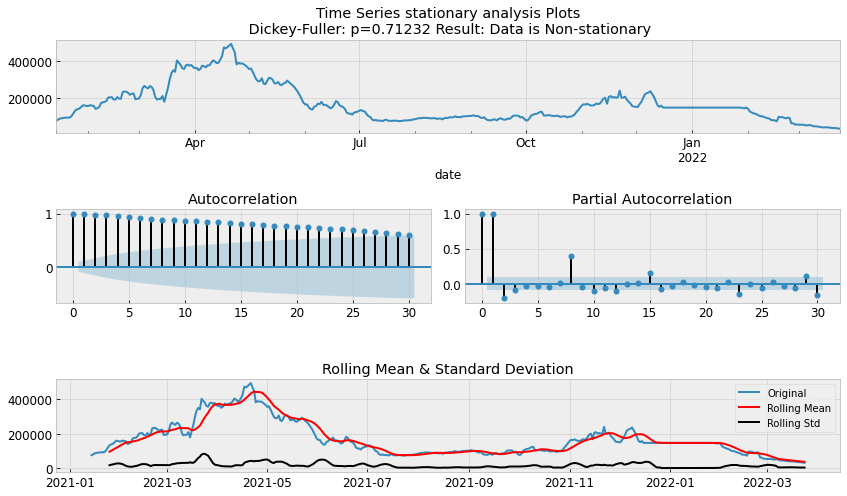

In [856]:
tsplot(vaccination_series.shift(1).dropna(), lags=30)

In [857]:
train_set = diff[diff.index < '2021-09-15']

test_set = diff[diff.index > '2021-09-15']

In [858]:
from sklearn.preprocessing import Normalizer,StandardScaler,MinMaxScaler
scaler = StandardScaler()

In [859]:
import numpy as np

train_set = diff[diff.index < '2021-09-15']

test_set = diff[diff.index > '2021-09-15']

X, y = [], []
time_steps = 45
for i in range(len(train_set) - time_steps):
  x = train_set[i:(i+time_steps)]
  X.append(x)
  y.append(train_set[i+time_steps])
X = scaler.fit_transform(np.array(X))
y = scaler.fit_transform(np.array(y).reshape(-1,1)).reshape(-1,1)

split = int(len(X) * 0.8)
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [860]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [861]:
regressor = RandomForestRegressor(n_estimators=100, min_samples_split=7)

In [862]:
regressor.fit(np.squeeze(X_train, axis = 1),y_train)

RandomForestRegressor(min_samples_split=7)

In [863]:
y_pred = regressor.predict(np.squeeze(X_test, axis = 1))
rmse = mean_squared_error(y_test,y_pred)**.5
rmse

1.5197150052521646

In [864]:
a = np.concatenate((y_train,y_test))

In [865]:
y_pred.shape[0]

40

RMSE 1.5197150052521646


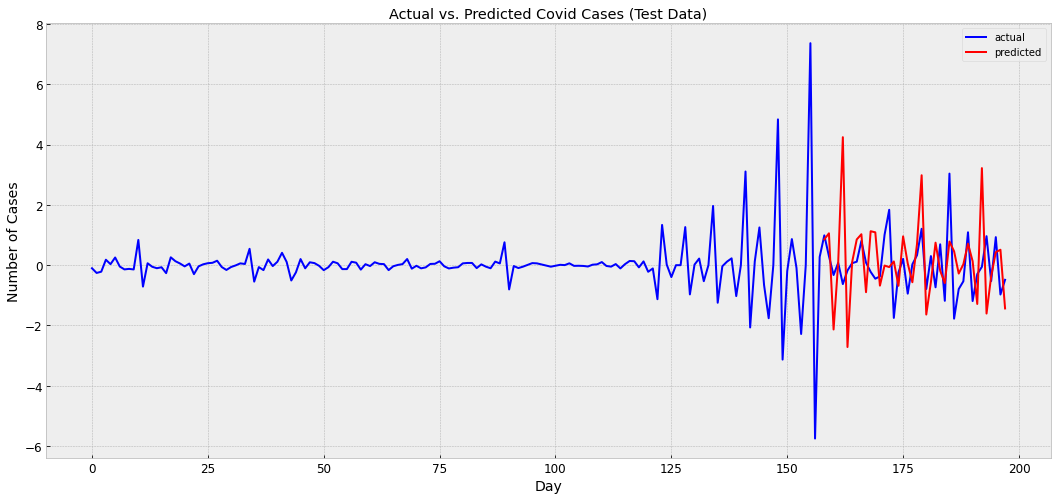

In [866]:
y_pred = regressor.predict(np.squeeze(X_test, axis = 1))
rmse = mean_squared_error(y_test,y_pred)**.5
print('RMSE', rmse)
a = np.concatenate((y_train,y_test))
plt.plot(a, color='blue', label='actual')
plt.plot(range(y_train.shape[0], y_train.shape[0] + y_pred.shape[0]), y_pred, color='red', label='predicted')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()

In [867]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_set.values, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  243
Model:                     ARMA(1, 1)   Log Likelihood               -2337.308
Method:                       css-mle   S.D. of innovations           3635.128
Date:                Fri, 29 Apr 2022   AIC                           4682.616
Time:                        22:54:24   BIC                           4696.589
Sample:                             0   HQIC                          4688.244
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -109.3292     75.568     -1.447      0.149    -257.441      38.782
ar.L1.y        0.0538      0.083      0.650      0.516      -0.108       0.216
ma.L1.y       -0.6964      0.050    -13.860      0.0

In [868]:
predicted_result = model.predict(test_set)

190
190


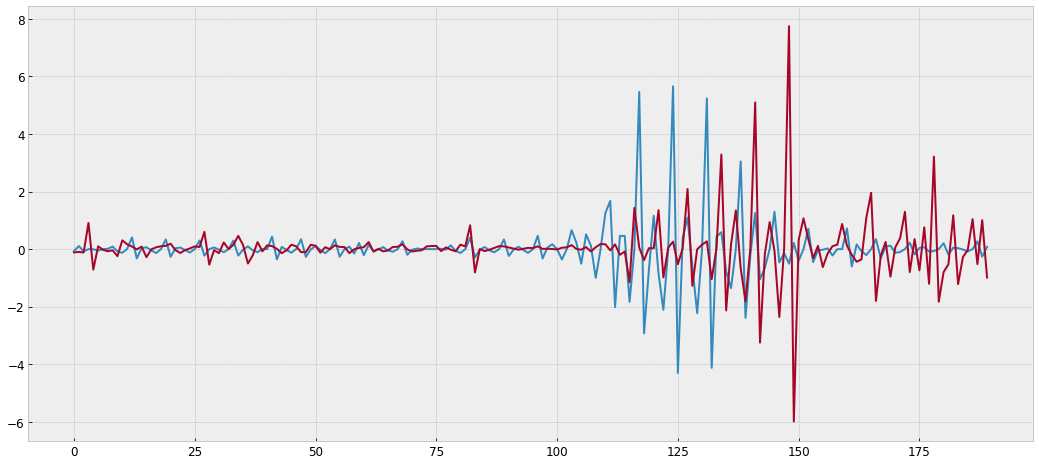

In [869]:
#plt.plot(predicted_result)
scaler = StandardScaler()
test= scaler.fit_transform(test_set.values.reshape(-1,1)).flatten()
print(len(test))

predicted = scaler.fit_transform(predicted_result.reshape(-1,1)).flatten()
print(len(predicted[53:]))
plt.close()
plt.plot(test)
plt.plot(predicted[53:])
plt.show()


In [870]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=20)
regressor.fit(np.squeeze(X_train, axis=1),y_train)

y_pred = regressor.predict(np.squeeze(X_test, axis = 1))
rmse = mean_squared_error(y_test,y_pred)**.5
rmse

1.57324617538858

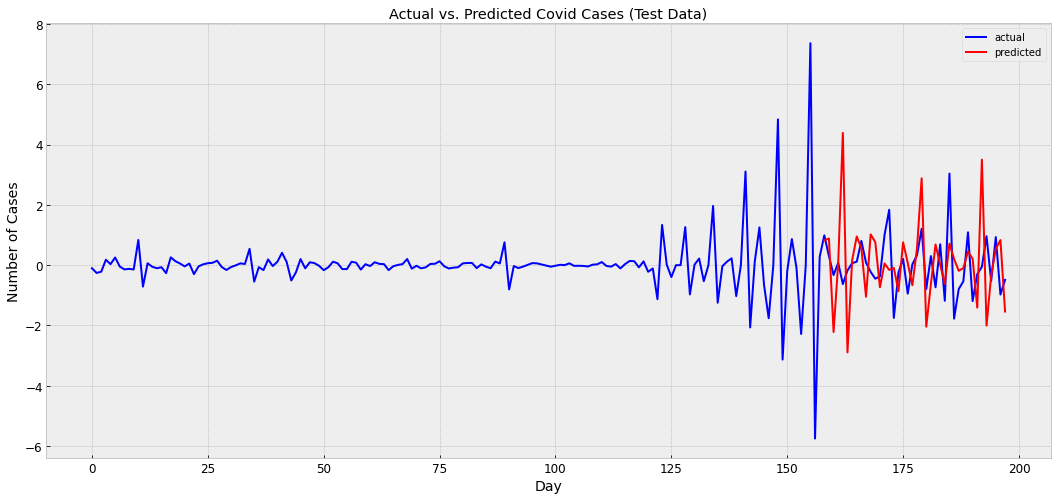

In [871]:

a = np.concatenate((y_train,y_test))
plt.plot(a, color='blue', label='actual')
plt.plot(range(y_train.shape[0], y_train.shape[0] + y_pred.shape[0]), y_pred, color='red', label='predicted')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()

In [872]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(Input(shape=(1, time_steps)))
model.add(LSTM(90, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(90))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mean_squared_error'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 1, 90)             48960     
                                                                 
 dropout_37 (Dropout)        (None, 1, 90)             0         
                                                                 
 lstm_38 (LSTM)              (None, 1, 48)             26688     
                                                                 
 dropout_38 (Dropout)        (None, 1, 48)             0         
                                                                 
 lstm_39 (LSTM)              (None, 90)                50040     
                                                                 
 dropout_39 (Dropout)        (None, 90)                0         
                                                                 
 dense_11 (Dense)            (None, 1)               

In [873]:
from keras.callbacks import ReduceLROnPlateau
batchsize = 32
epochs =  100
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)
history = model.fit(X_train,
                    y_train,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

Epoch 1/100
4/4 [==============================] - 6s 381ms/step - loss: 0.0637 - mean_squared_error: 0.0637 - val_loss: 4.8358 - val_mean_squared_error: 4.8358 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 4.8267 - val_mean_squared_error: 4.8267 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 4.8153 - val_mean_squared_error: 4.8153 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 4.8005 - val_mean_squared_error: 4.8005 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0619 - mean_squared_error: 0.0619 - val_loss: 4.7804 - val_mean_squared_error: 4.7804 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0609 - mean_squared_error: 0.0609 - val_loss: 4.7514 - val_m

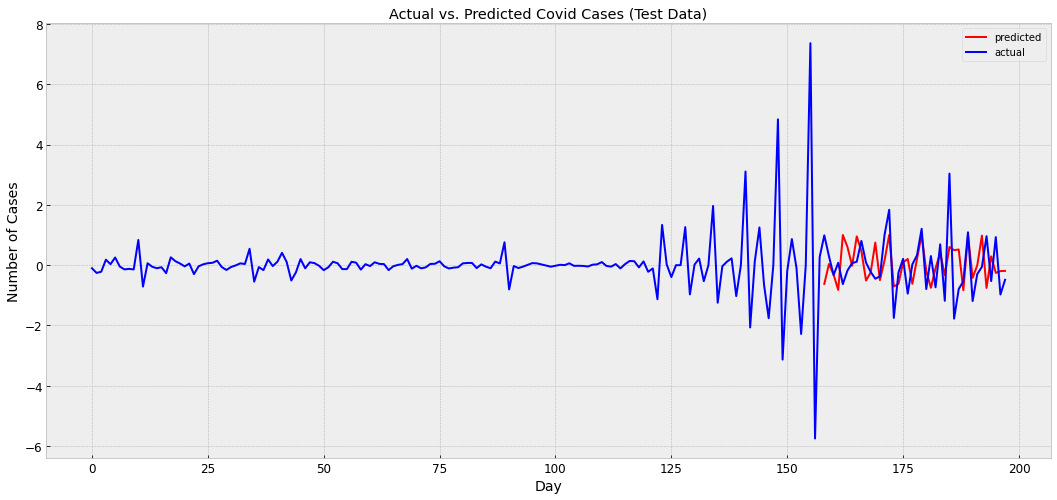

In [874]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

y_pred = model.predict(X_test)
total = np.concatenate((y_train,y_test))

# #print(y_test)
# print(len(total)-len(y_test))
# # y_pred = scaler.inverse_transform(y_pred)
t = range(len(total) - len(y_test), len(total))
#y_test = scaler.inverse_transform(y_test.reshape(-1,1))
plt.plot(t, y_pred, color='red')
plt.plot(total, color='blue')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])

In [875]:
rmse = mean_squared_error(y_test,y_pred)**.5
rmse

0.9598012831105939

In [876]:
np.concatenate((y_train,y_test)).shape

(198, 1)

In [877]:
vaccination_and_case = df_covid.new_case + df_covid.daily_vaccinations

In [878]:
vaccination_and_case.index = df_covid.date

In [879]:
vaccination_and_case

date
2021-01-13    108939.0
2021-01-14    115426.0
2021-01-15    128208.0
2021-01-16    129003.0
2021-01-17    132308.0
                ...   
2022-03-20     35096.0
2022-03-21     48979.0
2022-03-22     33275.0
2022-03-23     36388.0
2022-03-24     35412.0
Length: 436, dtype: float64

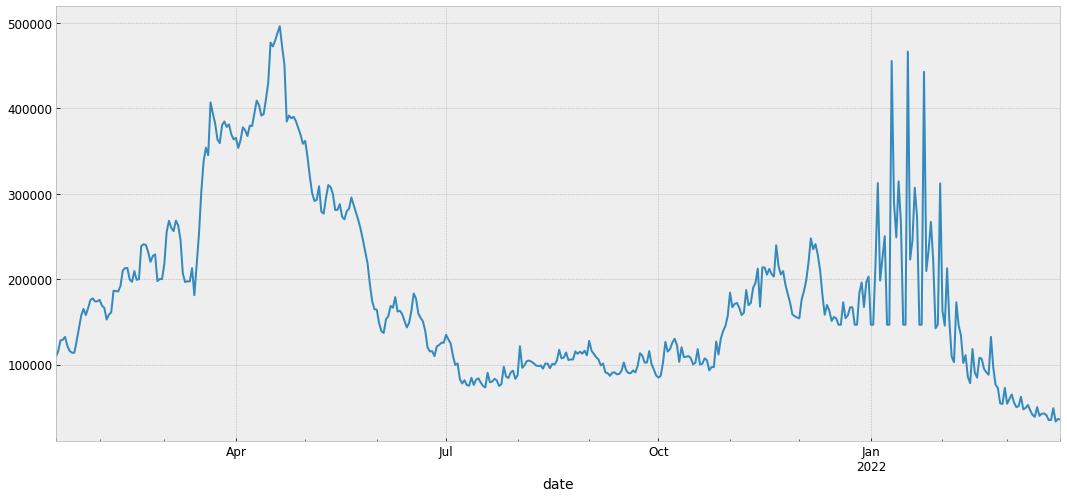

In [880]:
vaccination_and_case.plot()

In [881]:
import numpy as np

train_set = vaccination_and_case[vaccination_and_case.index < '2021-09-15']

test_set = vaccination_and_case[vaccination_and_case.index > '2021-09-15']

X, y = [], []
time_steps = 45
for i in range(len(train_set) - time_steps):
  x = train_set[i:(i+time_steps)]
  X.append(x)
  y.append(train_set[i+time_steps])
X = scaler.fit_transform(np.array(X))
y = scaler.fit_transform(np.array(y).reshape(-1,1)).reshape(-1,1)

split = int(len(X) * 0.8)
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [882]:
regressor = RandomForestRegressor(n_estimators=100, min_samples_split=7)

In [883]:
from numpy.core.fromnumeric import squeeze
regressor.fit(np.squeeze(X_train, axis =1 ), y_train)

RandomForestRegressor(min_samples_split=7)

RMSE 0.07645031173096777


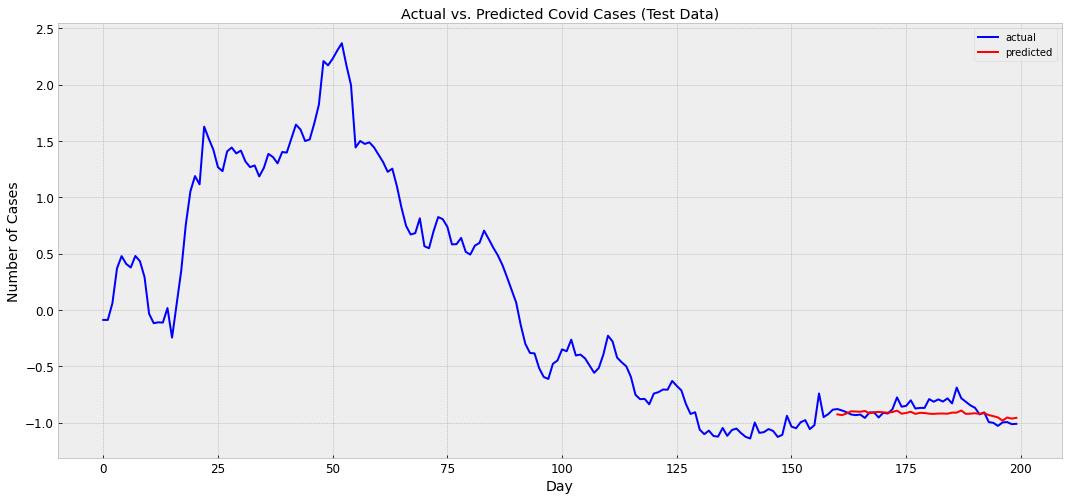

In [884]:
y_pred = regressor.predict(np.squeeze(X_test, axis =1 ))
rmse = mean_squared_error(y_test,y_pred)**.5
print('RMSE', rmse)
a = np.concatenate((y_train,y_test))
plt.plot(a, color='blue', label='actual')
plt.plot(range(y_train.shape[0], y_train.shape[0] + y_pred.shape[0]), y_pred, color='red', label='predicted')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()

In [885]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(Input(shape=(1, time_steps)))
model.add(LSTM(180, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(90, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(60, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(90))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mean_squared_error'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 1, 180)            162720    
                                                                 
 dropout_40 (Dropout)        (None, 1, 180)            0         
                                                                 
 lstm_41 (LSTM)              (None, 1, 90)             97560     
                                                                 
 dropout_41 (Dropout)        (None, 1, 90)             0         
                                                                 
 lstm_42 (LSTM)              (None, 1, 60)             36240     
                                                                 
 dropout_42 (Dropout)        (None, 1, 60)             0         
                                                                 
 lstm_43 (LSTM)              (None, 1, 48)           

In [886]:
from keras.callbacks import ReduceLROnPlateau
batchsize = 32
epochs =  100
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-2)
history = model.fit(X_train,
                    y_train,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

Epoch 1/100
4/4 [==============================] - 9s 609ms/step - loss: 1.0421 - mean_squared_error: 1.0421 - val_loss: 1.1068 - val_mean_squared_error: 1.1068 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 1.0263 - mean_squared_error: 1.0263 - val_loss: 1.1286 - val_mean_squared_error: 1.1286 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 1.0102 - mean_squared_error: 1.0102 - val_loss: 1.1482 - val_mean_squared_error: 1.1482 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 0.9884 - mean_squared_error: 0.9884 - val_loss: 1.1646 - val_mean_squared_error: 1.1646 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 0s 21ms/step - loss: 0.9551 - mean_squared_error: 0.9551 - val_loss: 1.1758 - val_mean_squared_error: 1.1758 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.9000 - mean_squared_error: 0.9000 - val_loss: 1.1793 - val_m

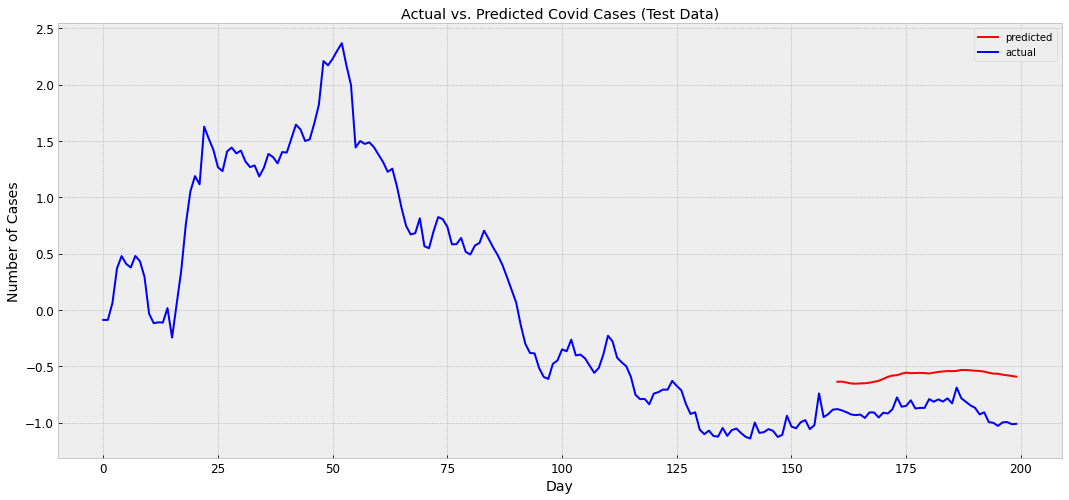

In [887]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

y_pred = model.predict(X_test)
total = np.concatenate((y_train,y_test))

# #print(y_test)
# print(len(total)-len(y_test))
# # y_pred = scaler.inverse_transform(y_pred)
t = range(len(total) - len(y_test), len(total))
#y_test = scaler.inverse_transform(y_test.reshape(-1,1))
plt.plot(t, y_pred, color='red')
plt.plot(total, color='blue')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])

In [888]:
mse_ = mean_squared_error(y_test, y_pred)

In [889]:
mse_**.5

0.3147462120050787

In [890]:
model = XGBRegressor(n_estimators=20)
regressor.fit(np.squeeze(X_train),y_train)

y_pred = regressor.predict(np.squeeze(X_test))
rmse = mean_squared_error(y_test,y_pred)**.5
rmse

0.0820712660214354

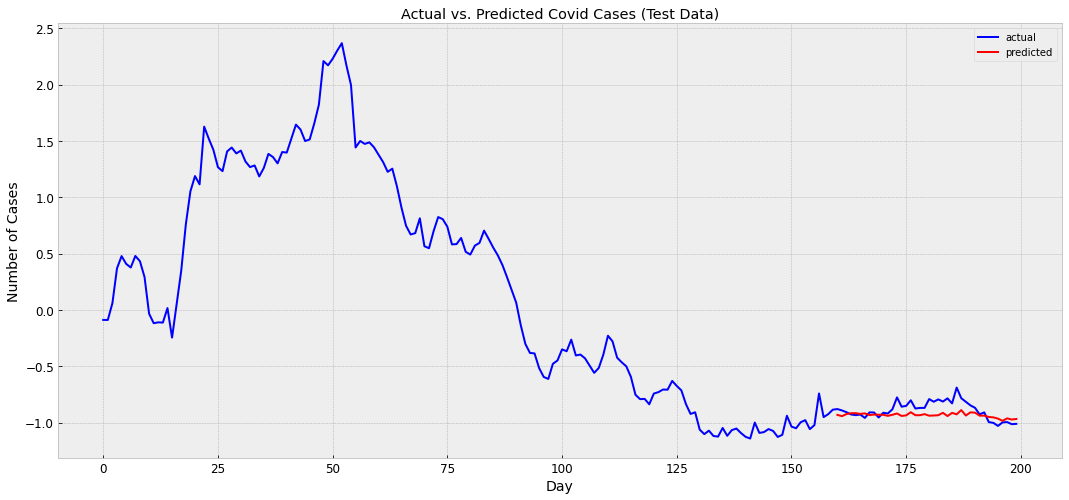

In [891]:
a = np.concatenate((y_train,y_test))
plt.plot(np.squeeze(a,axis = 1), color='blue', label='actual')
plt.plot(range(y_train.shape[0], y_train.shape[0] + y_pred.shape[0]), y_pred, color='red', label='predicted')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()

In [892]:
a.shape

(200, 1)

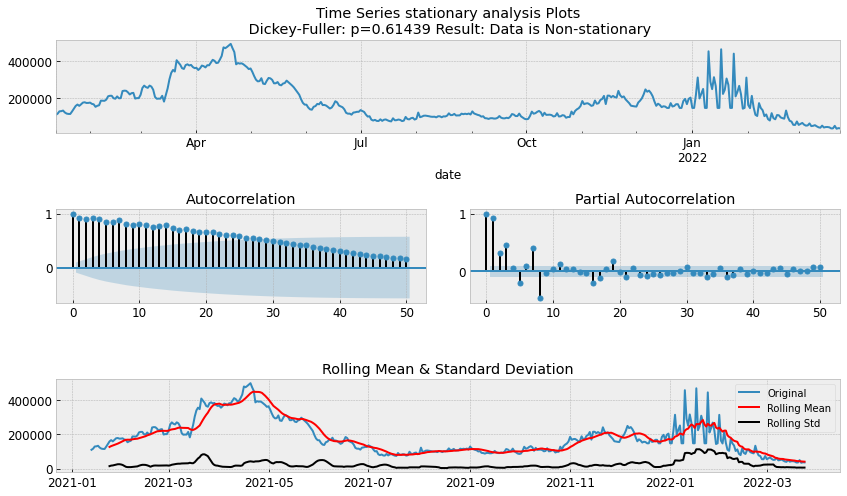

In [893]:
tsplot(vaccination_and_case, lags=50)